In [1]:
NEURON_LAYER = 256
EPOCH = 250
ATTR_NOW = 'sunshine'

In [2]:
attr_dict = {
    'min_temp': ('mnt', 'Temperatur minimum'),
    'max_temp': ('mxt', 'Temperatur maksimum'),
    'avg_temp': ('avgt', 'Temperatur rata-rata'),
    'humidity': ('hum', 'Kelembapan rata-rata'),
    'sunshine': ('sun', 'Penyinaran matahari'),
    'rainfall': ('rain', 'Curah hujan'),
}

ATTR_CODE = attr_dict[ATTR_NOW][0]
ATTR_NAME = attr_dict[ATTR_NOW][1]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.graphics.tsaplots as sgt
import random

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [4]:
random.seed(7)

In [5]:
df = pd.read_csv('../attributes_dataset/sunshine.csv')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.columns = ['y']
df.head()

,y
date,
2016-01-01,4.1
2016-01-02,8.6
2016-01-03,8.4
2016-01-04,3.3
2016-01-05,3.5


# Convert Dataframe to Array

In [6]:
def df_to_array(df, window_size):
    df_y_np = df.y.to_numpy()
    df_index_np = df.index.to_numpy()
    
    x = []
    y = []
    date = []
    for i in range(len(df_index_np) - window_size):
        row = [[a] for a in df_y_np[i:i+window_size]]
        x.append(row)
        label = df_y_np[i+window_size]
        y.append(label)
        index = df_index_np[i+window_size]
        date.append(index)
        
    return np.array(x), np.array(y), np.array(date)

# Configure time step

In [7]:
WINDOW_SIZE = 20

# Split the Data

In [8]:
train_ratio = int(len(df) * 0.8)
test_ratio = train_ratio + int(len(df) * 0.1)

dtrain, dval, dtest = df.iloc[:train_ratio], df.iloc[(train_ratio - WINDOW_SIZE):test_ratio], df.iloc[(test_ratio - WINDOW_SIZE):]

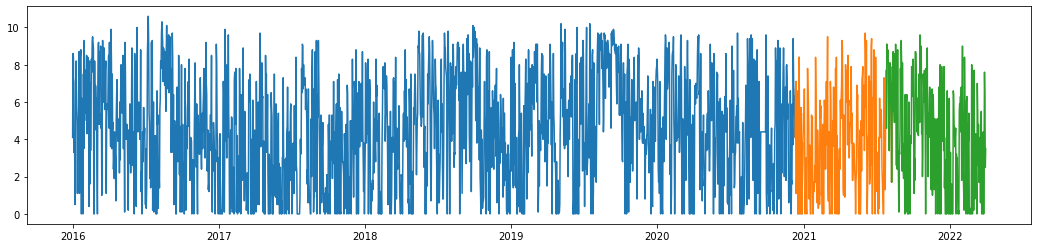

In [9]:
plt.figure(figsize=(18,4))
plt.plot(dtrain)
plt.plot(dval)
plt.plot(dtest)

# Standarization Function

In [10]:
dev_val = dtrain.std()[0]
mean_val = dtrain.mean()[0]

def make_std(data):
    data_std = data    
    data_std = (data_std-mean_val)/dev_val
    
    return data_std

In [11]:
dtrain_std = make_std(dtrain)

In [12]:
dval_std = make_std(dval)

In [13]:
dtest_std = make_std(dtest)

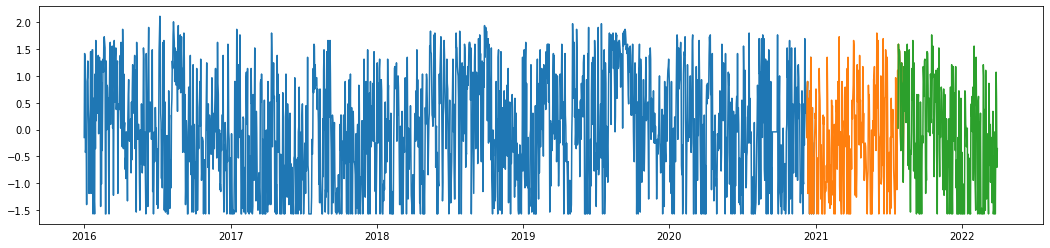

In [14]:
plt.figure(figsize=(18,4))
plt.plot(dtrain_std)
plt.plot(dval_std)
plt.plot(dtest_std)

# De-standarization Function

In [15]:
def de_std(df):
    column = ['Predictions', 'Actuals']
    for index, row in df.iterrows():
        for col in column:
            val = df.loc[index, col]
            df.loc[index, col] = (dev_val * val) + mean_val        

# Executing Forecast

In [16]:
def execute_forecast(pred, actual, date):
    df_result = pd.DataFrame(data={'date': date, 'Predictions': pred, 'Actuals': actual})
    df_result.set_index('date', inplace=True)
    
    de_std(df_result)
    
    plt.figure(figsize=(18,8))
    plt.plot(df_result['Actuals'], 'r--')
    plt.plot(df_result['Predictions'], 'b')

    plt.show()
    
    MAE = mean_absolute_error(df_result['Actuals'], df_result['Predictions'])
    RMSE = sqrt(mean_squared_error(df_result['Actuals'], df_result['Predictions']))

    print(f'Mean Absolute Error is\t\t: {MAE}')
    print(f'Root Mean Squared Error is\t: {RMSE}')
    
    return df_result, MAE, RMSE

## Get x and y values

In [17]:
X_train, y_train, date_train = df_to_array(dtrain_std, WINDOW_SIZE)
X_val, y_val, date_val = df_to_array(dval_std, WINDOW_SIZE)
X_test, y_test, date_test = df_to_array(dtest_std, WINDOW_SIZE)

# Creating the Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [19]:
model_loc = 'LSTM_models/'+ATTR_CODE+'_n'+str(NEURON_LAYER)+'_e'+str(EPOCH)+'/'

# Create and saving the Model

In [20]:
model = Sequential()
model.add(InputLayer((WINDOW_SIZE,1)))
model.add(LSTM(NEURON_LAYER))
model.add(Dense(64, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 280,705
Trainable params: 280,705
Non-trainable params: 0
_________________________________________________________________


In [21]:
cp = ModelCheckpoint(model_loc, save_best_only=True)

In [22]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [23]:
%%time
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCH, callbacks=[cp])

Epoch 1/250
56/57 [============================>.] - ETA: 0s - loss: 0.9124 - root_mean_squared_error: 0.9552

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 11s 154ms/step - loss: 0.9125 - root_mean_squared_error: 0.9553 - val_loss: 0.8520 - val_root_mean_squared_error: 0.9230
Epoch 2/250
56/57 [============================>.] - ETA: 0s - loss: 0.8436 - root_mean_squared_error: 0.9185

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 8s 149ms/step - loss: 0.8427 - root_mean_squared_error: 0.9180 - val_loss: 0.8334 - val_root_mean_squared_error: 0.9129
Epoch 3/250
56/57 [============================>.] - ETA: 0s - loss: 0.8216 - root_mean_squared_error: 0.9064

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 8s 150ms/step - loss: 0.8220 - root_mean_squared_error: 0.9067 - val_loss: 0.8185 - val_root_mean_squared_error: 0.9047
Epoch 4/250
56/57 [============================>.] - ETA: 0s - loss: 0.8123 - root_mean_squared_error: 0.9013

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 8s 139ms/step - loss: 0.8123 - root_mean_squared_error: 0.9013 - val_loss: 0.8100 - val_root_mean_squared_error: 0.9000
Epoch 5/250
56/57 [============================>.] - ETA: 0s - loss: 0.8062 - root_mean_squared_error: 0.8979

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 9s 153ms/step - loss: 0.8052 - root_mean_squared_error: 0.8973 - val_loss: 0.8011 - val_root_mean_squared_error: 0.8950
Epoch 6/250
56/57 [============================>.] - ETA: 0s - loss: 0.7990 - root_mean_squared_error: 0.8938

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 9s 157ms/step - loss: 0.7984 - root_mean_squared_error: 0.8935 - val_loss: 0.7937 - val_root_mean_squared_error: 0.8909
Epoch 7/250
56/57 [============================>.] - ETA: 0s - loss: 0.7947 - root_mean_squared_error: 0.8915

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 10s 180ms/step - loss: 0.7945 - root_mean_squared_error: 0.8913 - val_loss: 0.7895 - val_root_mean_squared_error: 0.8885
Epoch 8/250
56/57 [============================>.] - ETA: 0s - loss: 0.7924 - root_mean_squared_error: 0.8902

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 9s 163ms/step - loss: 0.7922 - root_mean_squared_error: 0.8901 - val_loss: 0.7862 - val_root_mean_squared_error: 0.8867
Epoch 9/250
56/57 [============================>.] - ETA: 0s - loss: 0.7897 - root_mean_squared_error: 0.8886

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 9s 154ms/step - loss: 0.7899 - root_mean_squared_error: 0.8888 - val_loss: 0.7841 - val_root_mean_squared_error: 0.8855
Epoch 10/250
56/57 [============================>.] - ETA: 0s - loss: 0.7913 - root_mean_squared_error: 0.8896

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 9s 162ms/step - loss: 0.7902 - root_mean_squared_error: 0.8889 - val_loss: 0.7788 - val_root_mean_squared_error: 0.8825
Epoch 11/250
57/57 [==============================] - 3s 59ms/step - loss: 0.7879 - root_mean_squared_error: 0.8876 - val_loss: 0.7801 - val_root_mean_squared_error: 0.8833
Epoch 12/250
56/57 [============================>.] - ETA: 0s - loss: 0.7880 - root_mean_squared_error: 0.8877

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 8s 149ms/step - loss: 0.7871 - root_mean_squared_error: 0.8872 - val_loss: 0.7771 - val_root_mean_squared_error: 0.8815
Epoch 13/250
56/57 [============================>.] - ETA: 0s - loss: 0.7826 - root_mean_squared_error: 0.8847

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 8s 150ms/step - loss: 0.7850 - root_mean_squared_error: 0.8860 - val_loss: 0.7743 - val_root_mean_squared_error: 0.8800
Epoch 14/250
56/57 [============================>.] - ETA: 0s - loss: 0.7827 - root_mean_squared_error: 0.8847

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 8s 144ms/step - loss: 0.7828 - root_mean_squared_error: 0.8848 - val_loss: 0.7730 - val_root_mean_squared_error: 0.8792
Epoch 15/250
56/57 [============================>.] - ETA: 0s - loss: 0.7818 - root_mean_squared_error: 0.8842

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 9s 152ms/step - loss: 0.7825 - root_mean_squared_error: 0.8846 - val_loss: 0.7724 - val_root_mean_squared_error: 0.8789
Epoch 16/250
56/57 [============================>.] - ETA: 0s - loss: 0.7795 - root_mean_squared_error: 0.8829

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 9s 156ms/step - loss: 0.7825 - root_mean_squared_error: 0.8846 - val_loss: 0.7702 - val_root_mean_squared_error: 0.8776
Epoch 17/250
57/57 [==============================] - 3s 58ms/step - loss: 0.7803 - root_mean_squared_error: 0.8833 - val_loss: 0.7707 - val_root_mean_squared_error: 0.8779
Epoch 18/250
56/57 [============================>.] - ETA: 0s - loss: 0.7757 - root_mean_squared_error: 0.8807

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 8s 146ms/step - loss: 0.7787 - root_mean_squared_error: 0.8824 - val_loss: 0.7689 - val_root_mean_squared_error: 0.8769
Epoch 19/250
57/57 [==============================] - 3s 59ms/step - loss: 0.7787 - root_mean_squared_error: 0.8824 - val_loss: 0.7689 - val_root_mean_squared_error: 0.8769
Epoch 20/250
57/57 [==============================] - 3s 59ms/step - loss: 0.7786 - root_mean_squared_error: 0.8824 - val_loss: 0.7691 - val_root_mean_squared_error: 0.8770
Epoch 21/250
57/57 [==============================] - 3s 59ms/step - loss: 0.7773 - root_mean_squared_error: 0.8816 - val_loss: 0.7695 - val_root_mean_squared_error: 0.8772
Epoch 22/250
56/57 [============================>.] - ETA: 0s - loss: 0.7764 - root_mean_squared_error: 0.8811

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 9s 154ms/step - loss: 0.7756 - root_mean_squared_error: 0.8807 - val_loss: 0.7675 - val_root_mean_squared_error: 0.8760
Epoch 23/250
57/57 [==============================] - 3s 58ms/step - loss: 0.7745 - root_mean_squared_error: 0.8801 - val_loss: 0.7712 - val_root_mean_squared_error: 0.8782
Epoch 24/250
57/57 [==============================] - 3s 58ms/step - loss: 0.7754 - root_mean_squared_error: 0.8806 - val_loss: 0.7751 - val_root_mean_squared_error: 0.8804
Epoch 25/250
56/57 [============================>.] - ETA: 0s - loss: 0.7699 - root_mean_squared_error: 0.8774

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250\assets


57/57 [==============================] - 9s 153ms/step - loss: 0.7726 - root_mean_squared_error: 0.8790 - val_loss: 0.7671 - val_root_mean_squared_error: 0.8758
Epoch 26/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7748 - root_mean_squared_error: 0.8802 - val_loss: 0.7758 - val_root_mean_squared_error: 0.8808
Epoch 27/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7734 - root_mean_squared_error: 0.8794 - val_loss: 0.7698 - val_root_mean_squared_error: 0.8774
Epoch 28/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7720 - root_mean_squared_error: 0.8786 - val_loss: 0.7684 - val_root_mean_squared_error: 0.8766
Epoch 29/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7734 - root_mean_squared_error: 0.8794 - val_loss: 0.7720 - val_root_mean_squared_error: 0.8786
Epoch 30/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7682 - root_mean_squared_error: 0.8765 - val_loss: 0.7757 - val_root_m

57/57 [==============================] - 3s 58ms/step - loss: 0.7582 - root_mean_squared_error: 0.8707 - val_loss: 0.7744 - val_root_mean_squared_error: 0.8800
Epoch 73/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7577 - root_mean_squared_error: 0.8704 - val_loss: 0.7758 - val_root_mean_squared_error: 0.8808
Epoch 74/250
57/57 [==============================] - 3s 58ms/step - loss: 0.7601 - root_mean_squared_error: 0.8718 - val_loss: 0.7755 - val_root_mean_squared_error: 0.8806
Epoch 75/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7563 - root_mean_squared_error: 0.8697 - val_loss: 0.7744 - val_root_mean_squared_error: 0.8800
Epoch 76/250
57/57 [==============================] - 3s 58ms/step - loss: 0.7578 - root_mean_squared_error: 0.8705 - val_loss: 0.7741 - val_root_mean_squared_error: 0.8798
Epoch 77/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7586 - root_mean_squared_error: 0.8710 - val_loss: 0.7742 - val_root_me

57/57 [==============================] - 3s 56ms/step - loss: 0.7441 - root_mean_squared_error: 0.8626 - val_loss: 0.7834 - val_root_mean_squared_error: 0.8851
Epoch 120/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7383 - root_mean_squared_error: 0.8592 - val_loss: 0.7850 - val_root_mean_squared_error: 0.8860
Epoch 121/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7400 - root_mean_squared_error: 0.8602 - val_loss: 0.7795 - val_root_mean_squared_error: 0.8829
Epoch 122/250
57/57 [==============================] - 3s 57ms/step - loss: 0.7360 - root_mean_squared_error: 0.8579 - val_loss: 0.7765 - val_root_mean_squared_error: 0.8812
Epoch 123/250
57/57 [==============================] - 3s 56ms/step - loss: 0.7366 - root_mean_squared_error: 0.8583 - val_loss: 0.7798 - val_root_mean_squared_error: 0.8830
Epoch 124/250
57/57 [==============================] - 3s 51ms/step - loss: 0.7337 - root_mean_squared_error: 0.8565 - val_loss: 0.7797 - val_ro

57/57 [==============================] - 3s 57ms/step - loss: 0.6953 - root_mean_squared_error: 0.8338 - val_loss: 0.8127 - val_root_mean_squared_error: 0.9015
Epoch 167/250
57/57 [==============================] - 3s 57ms/step - loss: 0.6948 - root_mean_squared_error: 0.8335 - val_loss: 0.8180 - val_root_mean_squared_error: 0.9044
Epoch 168/250
57/57 [==============================] - 3s 57ms/step - loss: 0.6968 - root_mean_squared_error: 0.8347 - val_loss: 0.8159 - val_root_mean_squared_error: 0.9033
Epoch 169/250
57/57 [==============================] - 3s 56ms/step - loss: 0.6939 - root_mean_squared_error: 0.8330 - val_loss: 0.8124 - val_root_mean_squared_error: 0.9013
Epoch 170/250
57/57 [==============================] - 3s 56ms/step - loss: 0.6891 - root_mean_squared_error: 0.8301 - val_loss: 0.8230 - val_root_mean_squared_error: 0.9072
Epoch 171/250
57/57 [==============================] - 3s 56ms/step - loss: 0.6886 - root_mean_squared_error: 0.8298 - val_loss: 0.8129 - val_ro

57/57 [==============================] - 3s 55ms/step - loss: 0.5941 - root_mean_squared_error: 0.7708 - val_loss: 0.9785 - val_root_mean_squared_error: 0.9892
Epoch 214/250
57/57 [==============================] - 3s 56ms/step - loss: 0.5840 - root_mean_squared_error: 0.7642 - val_loss: 0.9815 - val_root_mean_squared_error: 0.9907
Epoch 215/250
57/57 [==============================] - 3s 56ms/step - loss: 0.5764 - root_mean_squared_error: 0.7592 - val_loss: 0.9910 - val_root_mean_squared_error: 0.9955
Epoch 216/250
57/57 [==============================] - 3s 56ms/step - loss: 0.5791 - root_mean_squared_error: 0.7610 - val_loss: 0.9969 - val_root_mean_squared_error: 0.9984
Epoch 217/250
57/57 [==============================] - 3s 56ms/step - loss: 0.5710 - root_mean_squared_error: 0.7556 - val_loss: 1.0044 - val_root_mean_squared_error: 1.0022
Epoch 218/250
57/57 [==============================] - 3s 56ms/step - loss: 0.5728 - root_mean_squared_error: 0.7568 - val_loss: 0.9716 - val_ro

# Load the Model

In [24]:
model1 = load_model(model_loc)

In [25]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 280,705
Trainable params: 280,705
Non-trainable params: 0
_________________________________________________________________


## Train Results

In [26]:
train_res = model1.predict(X_train).flatten()

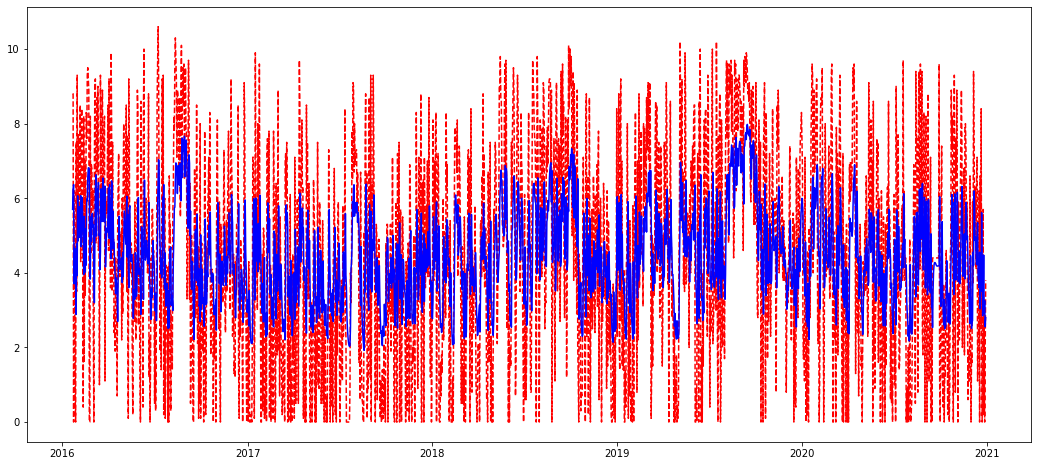

Mean Absolute Error is		: 2.0890999220745057
Root Mean Squared Error is	: 2.5255606100080867


In [27]:
train_df, train_MAE, train_RMSE = execute_forecast(train_res, y_train, date_train)

## Validation Results

In [28]:
val_res = model1.predict(X_val).flatten()

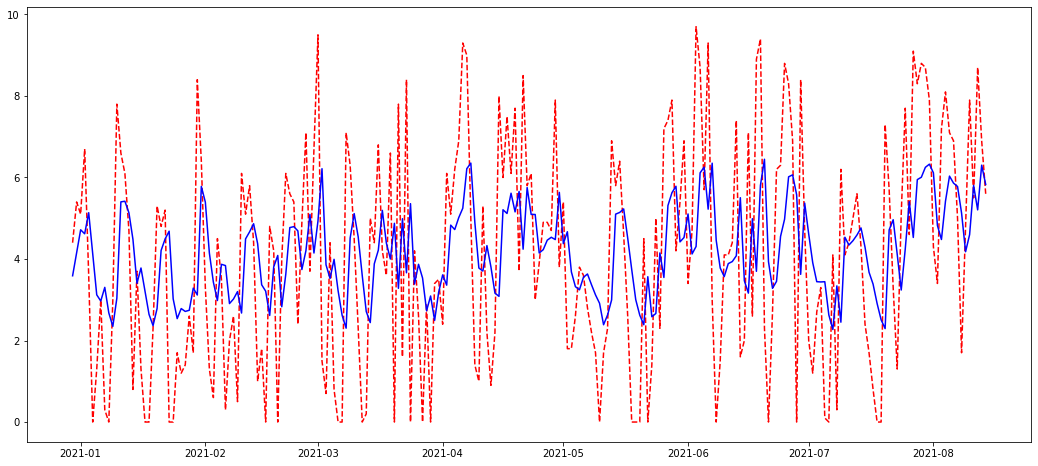

Mean Absolute Error is		: 2.0963511393781293
Root Mean Squared Error is	: 2.5159943297015928


In [29]:
val_df, val_MAE, val_RMSE = execute_forecast(val_res, y_val, date_val)

# Updating data validation to model

In [30]:
model_val_loc = model_loc[:-1] + '_val/'

In [31]:
u_cp = ModelCheckpoint(model_val_loc, save_best_only=True)

In [32]:
%%time
model1.fit(X_val, y_val, validation_data=(X_test, y_test), epochs=EPOCH, callbacks=[u_cp])

Epoch 1/250
8/8 [==============================] - ETA: 0s - loss: 0.7669 - root_mean_squared_error: 0.8757

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250_val\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250_val\assets


8/8 [==============================] - 9s 946ms/step - loss: 0.7669 - root_mean_squared_error: 0.8757 - val_loss: 0.8321 - val_root_mean_squared_error: 0.9122
Epoch 2/250
8/8 [==============================] - ETA: 0s - loss: 0.7600 - root_mean_squared_error: 0.8718

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250_val\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250_val\assets


8/8 [==============================] - 6s 858ms/step - loss: 0.7600 - root_mean_squared_error: 0.8718 - val_loss: 0.8317 - val_root_mean_squared_error: 0.9120
Epoch 3/250
8/8 [==============================] - 1s 125ms/step - loss: 0.7581 - root_mean_squared_error: 0.8707 - val_loss: 0.8378 - val_root_mean_squared_error: 0.9153
Epoch 4/250
8/8 [==============================] - 1s 123ms/step - loss: 0.7550 - root_mean_squared_error: 0.8689 - val_loss: 0.8368 - val_root_mean_squared_error: 0.9147
Epoch 5/250
8/8 [==============================] - 1s 123ms/step - loss: 0.7535 - root_mean_squared_error: 0.8680 - val_loss: 0.8358 - val_root_mean_squared_error: 0.9142
Epoch 6/250
8/8 [==============================] - 1s 122ms/step - loss: 0.7517 - root_mean_squared_error: 0.8670 - val_loss: 0.8366 - val_root_mean_squared_error: 0.9147
Epoch 7/250
8/8 [==============================] - 1s 123ms/step - loss: 0.7504 - root_mean_squared_error: 0.8663 - val_loss: 0.8335 - val_root_mean_squared_

INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250_val\assets


INFO:tensorflow:Assets written to: LSTM_models/sun_n256_e250_val\assets


8/8 [==============================] - 7s 918ms/step - loss: 0.7487 - root_mean_squared_error: 0.8653 - val_loss: 0.8298 - val_root_mean_squared_error: 0.9109
Epoch 9/250
8/8 [==============================] - 1s 122ms/step - loss: 0.7476 - root_mean_squared_error: 0.8647 - val_loss: 0.8352 - val_root_mean_squared_error: 0.9139
Epoch 10/250
8/8 [==============================] - 1s 120ms/step - loss: 0.7464 - root_mean_squared_error: 0.8640 - val_loss: 0.8395 - val_root_mean_squared_error: 0.9163
Epoch 11/250
8/8 [==============================] - 1s 120ms/step - loss: 0.7465 - root_mean_squared_error: 0.8640 - val_loss: 0.8400 - val_root_mean_squared_error: 0.9165
Epoch 12/250
8/8 [==============================] - 1s 120ms/step - loss: 0.7468 - root_mean_squared_error: 0.8642 - val_loss: 0.8428 - val_root_mean_squared_error: 0.9180
Epoch 13/250
8/8 [==============================] - 1s 120ms/step - loss: 0.7474 - root_mean_squared_error: 0.8645 - val_loss: 0.8481 - val_root_mean_squa

Epoch 56/250
8/8 [==============================] - 1s 121ms/step - loss: 0.7265 - root_mean_squared_error: 0.8523 - val_loss: 0.8601 - val_root_mean_squared_error: 0.9274
Epoch 57/250
8/8 [==============================] - 1s 119ms/step - loss: 0.7267 - root_mean_squared_error: 0.8525 - val_loss: 0.8638 - val_root_mean_squared_error: 0.9294
Epoch 58/250
8/8 [==============================] - 1s 121ms/step - loss: 0.7247 - root_mean_squared_error: 0.8513 - val_loss: 0.8580 - val_root_mean_squared_error: 0.9263
Epoch 59/250
8/8 [==============================] - 1s 121ms/step - loss: 0.7250 - root_mean_squared_error: 0.8515 - val_loss: 0.8640 - val_root_mean_squared_error: 0.9295
Epoch 60/250
8/8 [==============================] - 1s 122ms/step - loss: 0.7253 - root_mean_squared_error: 0.8517 - val_loss: 0.8568 - val_root_mean_squared_error: 0.9256
Epoch 61/250
8/8 [==============================] - 1s 122ms/step - loss: 0.7220 - root_mean_squared_error: 0.8497 - val_loss: 0.8513 - val_

8/8 [==============================] - 1s 122ms/step - loss: 0.7035 - root_mean_squared_error: 0.8388 - val_loss: 0.8683 - val_root_mean_squared_error: 0.9319
Epoch 104/250
8/8 [==============================] - 1s 122ms/step - loss: 0.7035 - root_mean_squared_error: 0.8387 - val_loss: 0.8720 - val_root_mean_squared_error: 0.9338
Epoch 105/250
8/8 [==============================] - 1s 122ms/step - loss: 0.7039 - root_mean_squared_error: 0.8390 - val_loss: 0.8690 - val_root_mean_squared_error: 0.9322
Epoch 106/250
8/8 [==============================] - 1s 121ms/step - loss: 0.7022 - root_mean_squared_error: 0.8380 - val_loss: 0.8630 - val_root_mean_squared_error: 0.9290
Epoch 107/250
8/8 [==============================] - 1s 121ms/step - loss: 0.7024 - root_mean_squared_error: 0.8381 - val_loss: 0.8668 - val_root_mean_squared_error: 0.9310
Epoch 108/250
8/8 [==============================] - 1s 121ms/step - loss: 0.7022 - root_mean_squared_error: 0.8379 - val_loss: 0.8711 - val_root_mea

8/8 [==============================] - 1s 120ms/step - loss: 0.6706 - root_mean_squared_error: 0.8189 - val_loss: 0.8938 - val_root_mean_squared_error: 0.9454
Epoch 151/250
8/8 [==============================] - 1s 120ms/step - loss: 0.6661 - root_mean_squared_error: 0.8162 - val_loss: 0.8937 - val_root_mean_squared_error: 0.9453
Epoch 152/250
8/8 [==============================] - 1s 120ms/step - loss: 0.6712 - root_mean_squared_error: 0.8193 - val_loss: 0.8968 - val_root_mean_squared_error: 0.9470
Epoch 153/250
8/8 [==============================] - 1s 121ms/step - loss: 0.6854 - root_mean_squared_error: 0.8279 - val_loss: 0.9411 - val_root_mean_squared_error: 0.9701
Epoch 154/250
8/8 [==============================] - 1s 121ms/step - loss: 0.6821 - root_mean_squared_error: 0.8259 - val_loss: 0.9046 - val_root_mean_squared_error: 0.9511
Epoch 155/250
8/8 [==============================] - 1s 122ms/step - loss: 0.6715 - root_mean_squared_error: 0.8195 - val_loss: 0.8921 - val_root_mea

8/8 [==============================] - 1s 121ms/step - loss: 0.6223 - root_mean_squared_error: 0.7889 - val_loss: 0.9511 - val_root_mean_squared_error: 0.9752
Epoch 198/250
8/8 [==============================] - 1s 121ms/step - loss: 0.6231 - root_mean_squared_error: 0.7894 - val_loss: 0.9486 - val_root_mean_squared_error: 0.9739
Epoch 199/250
8/8 [==============================] - 1s 120ms/step - loss: 0.6318 - root_mean_squared_error: 0.7949 - val_loss: 0.9411 - val_root_mean_squared_error: 0.9701
Epoch 200/250
8/8 [==============================] - 1s 122ms/step - loss: 0.6184 - root_mean_squared_error: 0.7864 - val_loss: 0.9625 - val_root_mean_squared_error: 0.9811
Epoch 201/250
8/8 [==============================] - 1s 121ms/step - loss: 0.6177 - root_mean_squared_error: 0.7860 - val_loss: 0.9773 - val_root_mean_squared_error: 0.9886
Epoch 202/250
8/8 [==============================] - 1s 122ms/step - loss: 0.6192 - root_mean_squared_error: 0.7869 - val_loss: 0.9531 - val_root_mea

8/8 [==============================] - 1s 122ms/step - loss: 0.5724 - root_mean_squared_error: 0.7565 - val_loss: 0.9973 - val_root_mean_squared_error: 0.9986
Epoch 245/250
8/8 [==============================] - 1s 121ms/step - loss: 0.5691 - root_mean_squared_error: 0.7544 - val_loss: 1.0060 - val_root_mean_squared_error: 1.0030
Epoch 246/250
8/8 [==============================] - 1s 123ms/step - loss: 0.5665 - root_mean_squared_error: 0.7526 - val_loss: 0.9975 - val_root_mean_squared_error: 0.9988
Epoch 247/250
8/8 [==============================] - 1s 122ms/step - loss: 0.5620 - root_mean_squared_error: 0.7497 - val_loss: 1.0054 - val_root_mean_squared_error: 1.0027
Epoch 248/250
8/8 [==============================] - 1s 122ms/step - loss: 0.5739 - root_mean_squared_error: 0.7575 - val_loss: 0.9805 - val_root_mean_squared_error: 0.9902
Epoch 249/250
8/8 [==============================] - 1s 121ms/step - loss: 0.5766 - root_mean_squared_error: 0.7593 - val_loss: 1.0099 - val_root_mea

## Test Results

In [33]:
model2 = load_model(model_val_loc)

In [34]:
test_res = model2.predict(X_test).flatten()

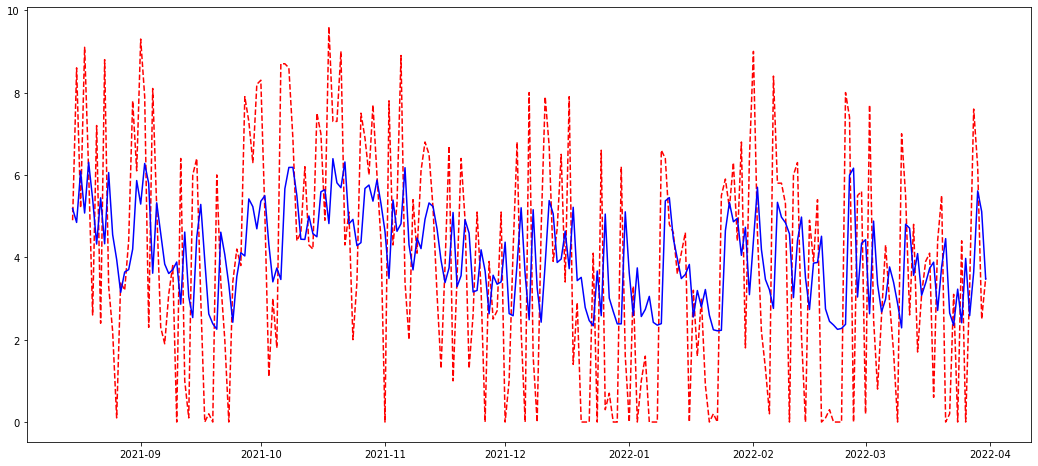

Mean Absolute Error is		: 2.1977663310854716
Root Mean Squared Error is	: 2.616798870407652


In [35]:
test_df, test_MAE, test_RMSE = execute_forecast(test_res, y_test, date_test)

# k-period forecast

In [36]:
def one_step_forecast(model, X):
    X_val = np.array(X)
    result = model.predict(X_val).flatten()
    X_val_update = []
    
    for lags in X_val:
        lags_update = []
        
        for value in lags:
            lags_update.append(value)
        
        lags_update.append(result)
        lags_update = lags_update[1:]
        
        X_val_update.append(lags_update)
    
    return result, np.array(X_val_update)

In [37]:
def LSTM_forecast(model, period, x_input):
    x_input = [x_input]
    final_result = []
    iteration = 0
    while iteration < period:
        result, x_input = one_step_forecast(model, x_input)
        final_result.append(result[0])
        iteration += 1
    return np.array(final_result), x_input

In [38]:
def get_period_forecast(model, X, period, date, y_act=[]):
    res = []
    pred_date = []
    for i in np.arange(0, len(X), period):
        X_start = X[i]
        result, __ = LSTM_forecast(model, period=period, x_input=X_start)
        
        ## updating model
        if len(y_act) > 0:
            for prd in range(0,period):
                if (i+prd) < len(X):
                    X_up = np.reshape(X[i+prd], (1, X.shape[1], X.shape[2]))
                    y_up = np.reshape(y_act[i+prd], (1,))
                    print(f"({i+prd}/{len(X)-1}) updating {date[i+prd]} into model")
                    model.fit(X_up, y_up, epochs=1)
                    
        res.append(result)
        pred_date.append(date[i])
    return np.array(res), np.array(pred_date)

In [39]:
def collect_k_res(k_res, length):
    res_val = []
    counter = 0
    for pred in k_res:
        for val in pred:
            if counter < length:
                res_val.append(val)
            counter += 1
    return np.array(res_val)

In [40]:
def period_forecast(model, period, X, y, date):
    k_res, k_date = get_period_forecast(model, X, period, date, y_act=y)
    k_res_val = collect_k_res(k_res, len(X))
    return k_res_val

In [41]:
def forcast_scene(model_loc, period, X, y, date):
    sc_model = load_model(model_loc)
    sc_frc = period_forecast(sc_model, period=period, X=X, y=y, date=date)
    sc_df, sc_MAE, sc_RMSE = execute_forecast(sc_frc, y_test, date_test)
    return sc_df, sc_MAE, sc_RMSE

# Forecasting scenario

(0/228) updating 2021-08-15T00:00:00.000000000 into model
1/1 [==============================] - 2s 2s/step - loss: 0.0099 - root_mean_squared_error: 0.0993
(1/228) updating 2021-08-16T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 1.7865 - root_mean_squared_error: 1.3366
(2/228) updating 2021-08-17T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 0.0886 - root_mean_squared_error: 0.2976
(3/228) updating 2021-08-18T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 1.9594 - root_mean_squared_error: 1.3998
(4/228) updating 2021-08-19T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787
(5/228) updating 2021-08-20T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 1.0230 - root_mean_squared_error: 1.0114
(6/228) updating 2021-08-21T00:00:00.000000000 i

1/1 [==============================] - 0s 26ms/step - loss: 0.4910 - root_mean_squared_error: 0.7007
(52/228) updating 2021-10-06T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 3.2576 - root_mean_squared_error: 1.8049
(53/228) updating 2021-10-07T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 1.2348 - root_mean_squared_error: 1.1112
(54/228) updating 2021-10-08T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 0.7779 - root_mean_squared_error: 0.8820
(55/228) updating 2021-10-09T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.0771 - root_mean_squared_error: 0.2777
(56/228) updating 2021-10-10T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 0.1350 - root_mean_squared_error: 0.3674
(57/228) updating 2021-10-11T00:00:00.000000000 into model
1/1 [==============================] - 0

1/1 [==============================] - 0s 27ms/step - loss: 0.1535 - root_mean_squared_error: 0.3918
(103/228) updating 2021-11-26T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 1.7923 - root_mean_squared_error: 1.3388
(104/228) updating 2021-11-27T00:00:00.000000000 into model
1/1 [==============================] - 0s 28ms/step - loss: 0.1243 - root_mean_squared_error: 0.3526
(105/228) updating 2021-11-28T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 0.1721 - root_mean_squared_error: 0.4149
(106/228) updating 2021-11-29T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 0.0732 - root_mean_squared_error: 0.2705
(107/228) updating 2021-11-30T00:00:00.000000000 into model
1/1 [==============================] - 0s 27ms/step - loss: 0.3032 - root_mean_squared_error: 0.5506
(108/228) updating 2021-12-01T00:00:00.000000000 into model
1/1 [=============================

1/1 [==============================] - 0s 28ms/step - loss: 0.1765 - root_mean_squared_error: 0.4201
(154/228) updating 2022-01-16T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 1.6241 - root_mean_squared_error: 1.2744
(155/228) updating 2022-01-17T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394
(156/228) updating 2022-01-18T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 0.2363 - root_mean_squared_error: 0.4862
(157/228) updating 2022-01-19T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074
(158/228) updating 2022-01-20T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.4930 - root_mean_squared_error: 0.7021
(159/228) updating 2022-01-21T00:00:00.000000000 into model
1/1 [=============================

1/1 [==============================] - 0s 22ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757
(205/228) updating 2022-03-08T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.2501 - root_mean_squared_error: 0.5001
(206/228) updating 2022-03-09T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 0.9510 - root_mean_squared_error: 0.9752
(207/228) updating 2022-03-10T00:00:00.000000000 into model
1/1 [==============================] - 0s 27ms/step - loss: 2.6413 - root_mean_squared_error: 1.6252
(208/228) updating 2022-03-11T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(209/228) updating 2022-03-12T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 0.3213 - root_mean_squared_error: 0.5669
(210/228) updating 2022-03-13T00:00:00.000000000 into model
1/1 [=============================

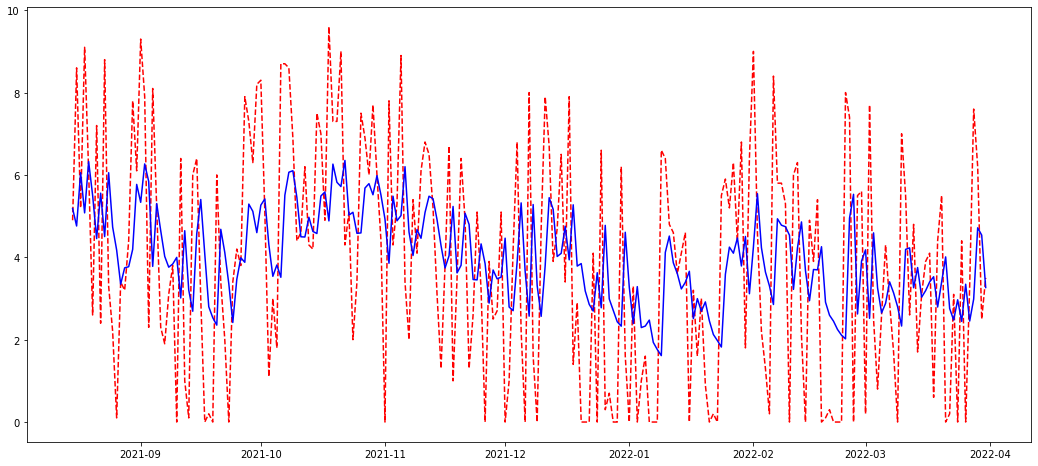

Mean Absolute Error is		: 2.218224677040067
Root Mean Squared Error is	: 2.6210517214764115


In [42]:
sc1_df, sc1_MAE, sc1_RMSE = forcast_scene(model_val_loc, period=1, X=X_test, y=y_test, date=date_test)

(0/228) updating 2021-08-15T00:00:00.000000000 into model
1/1 [==============================] - 2s 2s/step - loss: 0.0099 - root_mean_squared_error: 0.0993
(1/228) updating 2021-08-16T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 1.7865 - root_mean_squared_error: 1.3366
(2/228) updating 2021-08-17T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.0886 - root_mean_squared_error: 0.2976
(3/228) updating 2021-08-18T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 1.9594 - root_mean_squared_error: 1.3998
(4/228) updating 2021-08-19T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787
(5/228) updating 2021-08-20T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 1.0230 - root_mean_squared_error: 1.0114
(6/228) updating 2021-08-21T00:00:00.000000000 i

1/1 [==============================] - 0s 25ms/step - loss: 0.4910 - root_mean_squared_error: 0.7007
(52/228) updating 2021-10-06T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 3.2576 - root_mean_squared_error: 1.8049
(53/228) updating 2021-10-07T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 1.2348 - root_mean_squared_error: 1.1112
(54/228) updating 2021-10-08T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.7779 - root_mean_squared_error: 0.8820
(55/228) updating 2021-10-09T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 0.0771 - root_mean_squared_error: 0.2777
(56/228) updating 2021-10-10T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.1350 - root_mean_squared_error: 0.3674
(57/228) updating 2021-10-11T00:00:00.000000000 into model
1/1 [==============================] - 0

1/1 [==============================] - 0s 26ms/step - loss: 0.1535 - root_mean_squared_error: 0.3918
(103/228) updating 2021-11-26T00:00:00.000000000 into model
1/1 [==============================] - 0s 27ms/step - loss: 1.7923 - root_mean_squared_error: 1.3388
(104/228) updating 2021-11-27T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 0.1243 - root_mean_squared_error: 0.3526
(105/228) updating 2021-11-28T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 0.1721 - root_mean_squared_error: 0.4149
(106/228) updating 2021-11-29T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 0.0732 - root_mean_squared_error: 0.2705
(107/228) updating 2021-11-30T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.3032 - root_mean_squared_error: 0.5506
(108/228) updating 2021-12-01T00:00:00.000000000 into model
1/1 [=============================

1/1 [==============================] - 0s 20ms/step - loss: 0.1765 - root_mean_squared_error: 0.4201
(154/228) updating 2022-01-16T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 1.6241 - root_mean_squared_error: 1.2744
(155/228) updating 2022-01-17T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394
(156/228) updating 2022-01-18T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.2363 - root_mean_squared_error: 0.4862
(157/228) updating 2022-01-19T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074
(158/228) updating 2022-01-20T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.4930 - root_mean_squared_error: 0.7021
(159/228) updating 2022-01-21T00:00:00.000000000 into model
1/1 [=============================

1/1 [==============================] - 0s 23ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757
(205/228) updating 2022-03-08T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.2501 - root_mean_squared_error: 0.5001
(206/228) updating 2022-03-09T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.9510 - root_mean_squared_error: 0.9752
(207/228) updating 2022-03-10T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 2.6413 - root_mean_squared_error: 1.6252
(208/228) updating 2022-03-11T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(209/228) updating 2022-03-12T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.3213 - root_mean_squared_error: 0.5669
(210/228) updating 2022-03-13T00:00:00.000000000 into model
1/1 [=============================

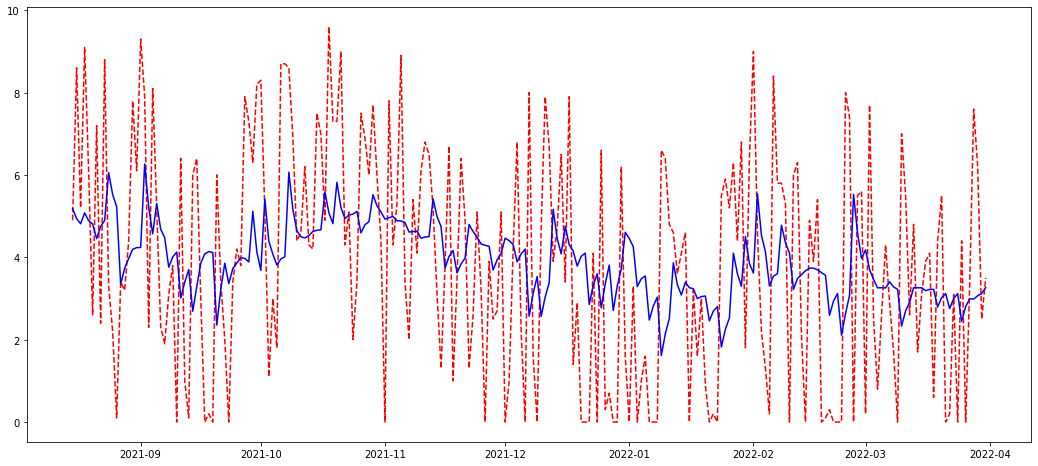

Mean Absolute Error is		: 2.2952115203615877
Root Mean Squared Error is	: 2.7057244393023256


In [43]:
sc2_df, sc2_MAE, sc2_RMSE = forcast_scene(model_val_loc, period=3, X=X_test, y=y_test, date=date_test)

(0/228) updating 2021-08-15T00:00:00.000000000 into model
1/1 [==============================] - 2s 2s/step - loss: 0.0099 - root_mean_squared_error: 0.0993
(1/228) updating 2021-08-16T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 1.7865 - root_mean_squared_error: 1.3366
(2/228) updating 2021-08-17T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.0886 - root_mean_squared_error: 0.2976
(3/228) updating 2021-08-18T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 1.9594 - root_mean_squared_error: 1.3998
(4/228) updating 2021-08-19T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787
(5/228) updating 2021-08-20T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 1.0230 - root_mean_squared_error: 1.0114
(6/228) updating 2021-08-21T00:00:00.000000000 i

1/1 [==============================] - 0s 20ms/step - loss: 0.4910 - root_mean_squared_error: 0.7007
(52/228) updating 2021-10-06T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 3.2576 - root_mean_squared_error: 1.8049
(53/228) updating 2021-10-07T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 1.2348 - root_mean_squared_error: 1.1112
(54/228) updating 2021-10-08T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.7779 - root_mean_squared_error: 0.8820
(55/228) updating 2021-10-09T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.0771 - root_mean_squared_error: 0.2777
(56/228) updating 2021-10-10T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.1350 - root_mean_squared_error: 0.3674
(57/228) updating 2021-10-11T00:00:00.000000000 into model
1/1 [==============================] - 0

1/1 [==============================] - 0s 20ms/step - loss: 0.1535 - root_mean_squared_error: 0.3918
(103/228) updating 2021-11-26T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 1.7923 - root_mean_squared_error: 1.3388
(104/228) updating 2021-11-27T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.1243 - root_mean_squared_error: 0.3526
(105/228) updating 2021-11-28T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 0.1721 - root_mean_squared_error: 0.4149
(106/228) updating 2021-11-29T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.0732 - root_mean_squared_error: 0.2705
(107/228) updating 2021-11-30T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.3032 - root_mean_squared_error: 0.5506
(108/228) updating 2021-12-01T00:00:00.000000000 into model
1/1 [=============================

1/1 [==============================] - 0s 19ms/step - loss: 0.1765 - root_mean_squared_error: 0.4201
(154/228) updating 2022-01-16T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 1.6241 - root_mean_squared_error: 1.2744
(155/228) updating 2022-01-17T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394
(156/228) updating 2022-01-18T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.2363 - root_mean_squared_error: 0.4862
(157/228) updating 2022-01-19T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074
(158/228) updating 2022-01-20T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.4930 - root_mean_squared_error: 0.7021
(159/228) updating 2022-01-21T00:00:00.000000000 into model
1/1 [=============================

1/1 [==============================] - 0s 21ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757
(205/228) updating 2022-03-08T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.2501 - root_mean_squared_error: 0.5001
(206/228) updating 2022-03-09T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.9510 - root_mean_squared_error: 0.9752
(207/228) updating 2022-03-10T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 2.6413 - root_mean_squared_error: 1.6252
(208/228) updating 2022-03-11T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(209/228) updating 2022-03-12T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.3213 - root_mean_squared_error: 0.5669
(210/228) updating 2022-03-13T00:00:00.000000000 into model
1/1 [=============================

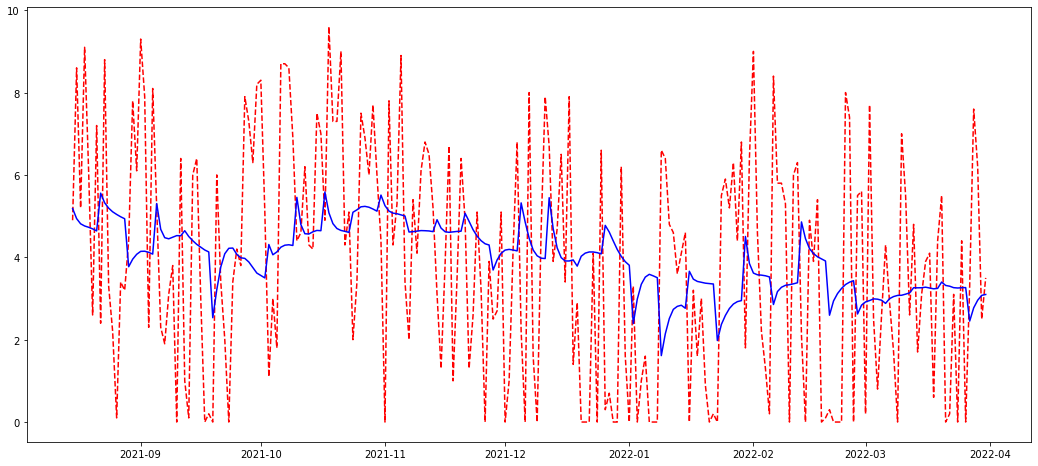

Mean Absolute Error is		: 2.3809632903103224
Root Mean Squared Error is	: 2.766241303217972


In [44]:
sc3_df, sc3_MAE, sc3_RMSE = forcast_scene(model_val_loc, period=7, X=X_test, y=y_test, date=date_test)

# Collecting All Predictions Scenario Result

In [45]:
def plot_forecasts_result(df):
    title = 'Peramalan ' + ATTR_NAME + ' LSTM'
    
    plt.figure(figsize=(18,8))
    plt.title(title)
    plt.plot(df['scn-1'], 'r-', label='1-step forecast')
    plt.plot(df['scn-2'], 'b-', label='3-step forecast')
    plt.plot(df['scn-3'], 'g-', label='7-step forecast')
    plt.plot(df['Actuals'], color='black', linestyle=':' , label='Actuals')
    plt.legend()

In [46]:
def col_forcasts_err(res_df):
    for col in [x for x in range(len(forecasts_result.columns)-1)]:
        col_name = res_df.columns[col]
        MAE = mean_absolute_error(res_df['Actuals'], res_df[col_name])
        RMSE = sqrt(mean_squared_error(res_df['Actuals'], res_df[col_name]))
        print('Error for ', col_name)
        print(f'Mean Absolute Error is\t\t: {MAE}')
        print(f'Root Mean Squared Error is\t: {RMSE}')
        print()

In [47]:
sc1_df_cp = sc1_df.copy()
sc1_df_cp.columns = ['scn-1', 'Actuals']

sc2_df_cp = sc2_df.copy()
sc2_df_cp.columns = ['scn-2', 'Actuals']

sc3_df_cp = sc3_df.copy()
sc3_df_cp.columns = ['scn-3', 'Actuals']

In [48]:
forecasts_result = pd.concat([sc1_df_cp[[sc1_df_cp.columns[0]]],
                              sc2_df_cp[[sc2_df_cp.columns[0]]],
                              sc3_df_cp[[sc3_df_cp.columns[0]]],
                              sc1_df_cp[[sc3_df_cp.columns[1]]]
                             ],
                               axis='columns')

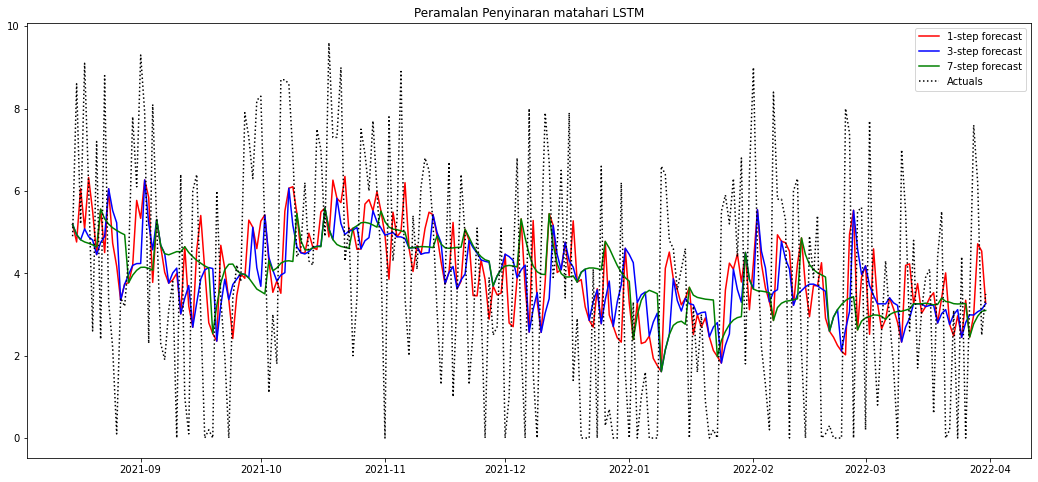

In [49]:
plot_forecasts_result(forecasts_result)

In [50]:
col_forcasts_err(forecasts_result)

Error for  scn-1
Mean Absolute Error is		: 2.218224677040067
Root Mean Squared Error is	: 2.6210517214764115

Error for  scn-2
Mean Absolute Error is		: 2.2952115203615877
Root Mean Squared Error is	: 2.7057244393023256

Error for  scn-3
Mean Absolute Error is		: 2.3809632903103224
Root Mean Squared Error is	: 2.766241303217972



## Saving forecasts result

In [51]:
forecasts_result.to_csv('LSTM_results_temp/'+ATTR_CODE+'_n'+str(NEURON_LAYER)+'_e'+str(EPOCH)+'.csv')

# Calling Forecasting Result

In [52]:
FILE_NEURON = NEURON_LAYER
FILE_EPOCH = EPOCH

In [53]:
df_call = pd.read_csv('LSTM_results_temp/'+ATTR_CODE+'_n'+str(FILE_NEURON)+'_e'+str(FILE_EPOCH)+'.csv')
df_call.date = pd.to_datetime(df_call.date, format='%Y-%m-%d')
df_call.set_index('date', inplace=True)
df_call.head()

,scn-1,scn-2,scn-3,Actuals
date,,,,
2021-08-15,5.185159,5.185159,5.185159,4.9
2021-08-16,4.760405,4.939649,4.939649,8.6
2021-08-17,6.054858,4.813700,4.813700,5.2
2021-08-18,5.078911,5.078911,4.760910,9.1
2021-08-19,6.326004,4.888727,4.729009,6.1


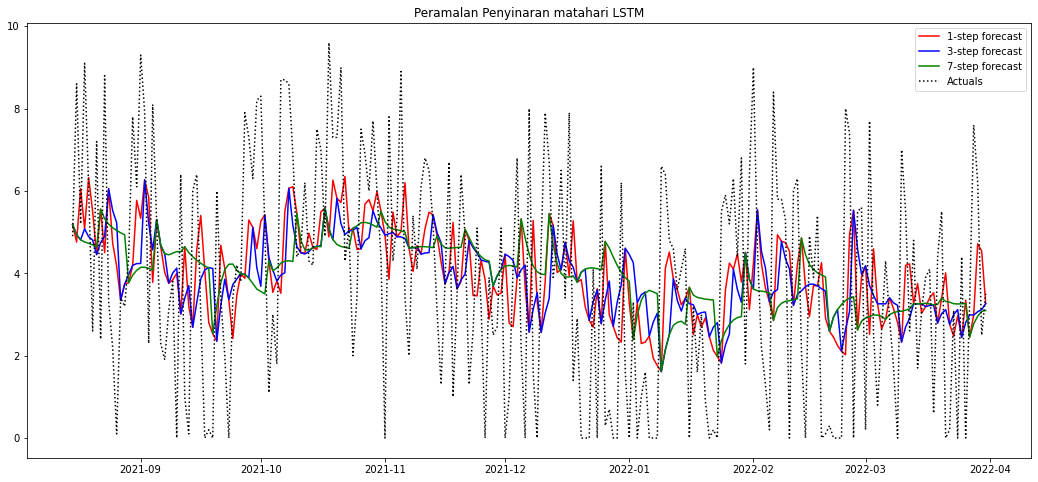

In [54]:
plot_forecasts_result(df_call)

In [55]:
col_forcasts_err(df_call)

Error for  scn-1
Mean Absolute Error is		: 2.218224670742358
Root Mean Squared Error is	: 2.6210517154608217

Error for  scn-2
Mean Absolute Error is		: 2.2952115244541487
Root Mean Squared Error is	: 2.705724440710484

Error for  scn-3
Mean Absolute Error is		: 2.3809633008733626
Root Mean Squared Error is	: 2.766241312461848

